In [ ]:
import pandas as pd


addr_tx = pd.read_csv('elliptic/AddrTx_edgelist.csv')
tx_addr = pd.read_csv('elliptic/TxAddr_edgelist.csv')
wallets = pd.read_csv('elliptic/wallets_classes.csv')
txs_features = pd.read_csv('elliptic/txs_features.csv')


tx_edges = pd.merge(addr_tx, tx_addr, on='txId', how='inner')
tx_edges = pd.merge(tx_edges, txs_features, on='txId', how='left')
tx_edges = pd.merge(tx_edges, wallets.rename(columns={'address': 'input_address', 'class': 'src_class'}),
                    on='input_address', how='left')
tx_edges = pd.merge(tx_edges, wallets.rename(columns={'address': 'output_address', 'class': 'dst_class'}),
                    on='output_address', how='left')

agg_edges = (
    tx_edges.groupby(['input_address', 'output_address', 'Time step', 'src_class', 'dst_class'])
    .size()
    .reset_index(name='weight')
)

agg_edges = agg_edges.rename(columns={
    'input_address': 'src_addr',
    'output_address': 'dst_addr',
    'Time step': 'time step'
})

agg_edges = agg_edges.sort_values(by='time step', ascending=True)
agg_edges.to_csv('elliptic/AddrAddr_timestep.csv', index=False)

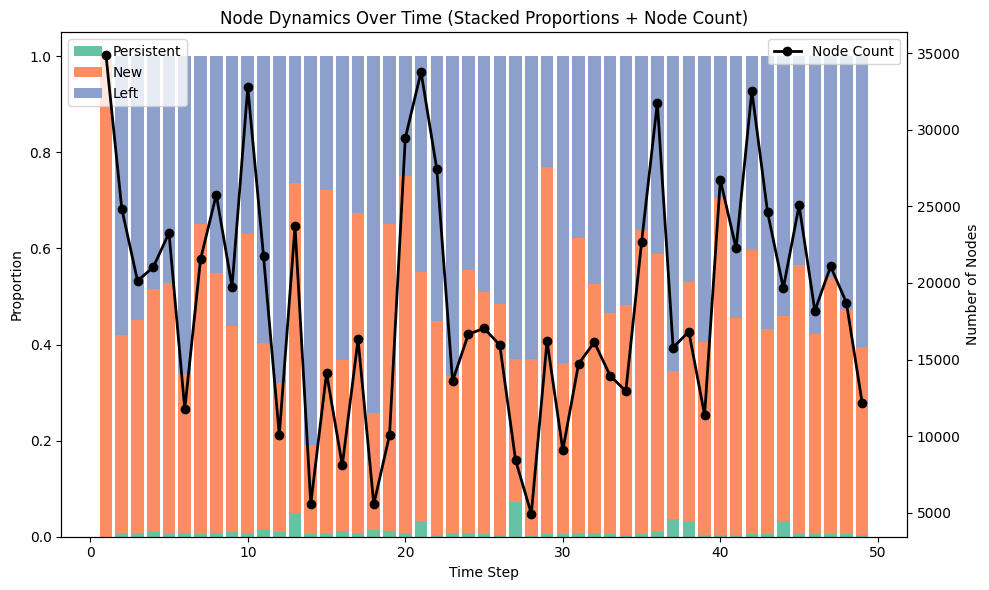

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取前面生成的文件
edges = pd.read_csv('elliptic/AddrAddr_timestep.csv')

# 1️⃣ 去除自环
edges = edges[edges['src_addr'] != edges['dst_addr']]

# 2️⃣ 获取每个时间步的节点集合
time_steps = sorted(edges['time step'].unique())
node_sets = {t: set(edges.loc[edges['time step'] == t, ['src_addr', 'dst_addr']].values.flatten())
             for t in time_steps}

# 3️⃣ 计算新增、离开、持续存在比例 + 节点总数
records = []
for i, t in enumerate(time_steps):
    current_nodes = node_sets[t]
    if i == 0:
        records.append({
            'time step': t,
            'new_nodes': 1.0,
            'left_nodes': 0.0,
            'persistent_nodes': 0.0,
            'num_nodes': len(current_nodes)
        })
    else:
        prev_nodes = node_sets[time_steps[i - 1]]
        new_nodes = current_nodes - prev_nodes
        left_nodes = prev_nodes - current_nodes
        persistent_nodes = current_nodes & prev_nodes
        total = len(current_nodes | prev_nodes)
        records.append({
            'time step': t,
            'new_nodes': len(new_nodes) / total if total > 0 else 0,
            'left_nodes': len(left_nodes) / total if total > 0 else 0,
            'persistent_nodes': len(persistent_nodes) / total if total > 0 else 0,
            'num_nodes': len(current_nodes)
        })

# 4️⃣ 转为DataFrame
df = pd.DataFrame(records)

# 5️⃣ 绘制堆叠柱状图 + 节点数量折线图
fig, ax1 = plt.subplots(figsize=(10, 6))

# 堆叠柱状图
ax1.bar(df['time step'], df['persistent_nodes'], label='Persistent', color='#66c2a5')
ax1.bar(df['time step'], df['new_nodes'], bottom=df['persistent_nodes'], label='New', color='#fc8d62')
ax1.bar(df['time step'], df['left_nodes'],
        bottom=df['persistent_nodes'] + df['new_nodes'], label='Left', color='#8da0cb')

ax1.set_xlabel('Time Step')
ax1.set_ylabel('Proportion')
ax1.set_ylim(0, 1.05)
ax1.legend(loc='upper left')

# 第二个y轴：节点总数折线
ax2 = ax1.twinx()
ax2.plot(df['time step'], df['num_nodes'], color='black', marker='o', linewidth=2, label='Node Count')
ax2.set_ylabel('Number of Nodes')
ax2.legend(loc='upper right')

plt.title('Node Dynamics Over Time (Stacked Proportions + Node Count)')
plt.tight_layout()
plt.show()